In [1]:
# 앞절에서 수행한 내용들

import os
import numpy as np
from sklearn.datasets import fetch_openml

dataset_root = os.path.join(os.getcwd(), 'datasets')
if not os.path.isdir(dataset_root):
    os.mkdir(dataset_root)

    
mnist = fetch_openml('mnist_784', version=1, data_home=dataset_root)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 5면 True, 아니면 False로 변환
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Performance Measures

classifier는 다양한 성능 측정이 가능하기 때문에 일반적으로 regressior보다 evaluation하기가 더욱 까다롭다.

#### 참고) Cross-Validation의 구현

가끔 사이킷런의 `cross_val_score()`에 몇가지 조작을 더 추가하기 위해 직접 구현해야 할 때가 있다. 다음은 `cross_val_score()`와 같은 결과를 출력하는 코드이다.

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


## Measuring Accuracy Using Cross-Validation

`cross_val_score()`를 통해 `SGDClassifier` 모델을 K-fold cross-validation을 사용해 evaluation해보자.

In [4]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(sgd_clf, X_train, y_train_5,
                      cv=3, scoring="accuracy"))

[0.95035 0.96035 0.9604 ]


위 결과를 보면 모든 fold에 대해 95%이상의 **accuracy**를 보인다. 

이는 상당히 좋은 결과지만, 만족하기 전에 다음의 단순한 classifier를 한번 보자.

In [5]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # 그냥 모두 False라고 반환
        return np.zeros((len(X), 1), dtype=bool)

In [6]:
never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5,
                      cv=3, scoring='accuracy'))

[0.91125 0.90855 0.90915]


10%의 이미지가 5이기 때문에 모두 5가 아니라고 예측해도 90% 이상의 결과를 내는 것을 볼 수 있다.

위의 결과는 classifier의 performance로 accuracy가 선호되지 않는 이유를 보여준다. 이는 특히 skewed dataset(class별로 불균형한 수의 data)의 경우에 더욱 그렇다.

## Confusion Matrix

classifier의 performance evaluation에 더욱 좋은 방법은 **confusion matrix**이다.

기본 아이디어는 class A의 instance가 class B로 분류되는 숫자를 세는 것이다. 예를 들어, 5를 3으로 헷갈린 경우의 수는 confusion matrix의 5행 3열 값을 보면 된다.

comfustion matrix를 계산하기 위해서는 먼저, 실제 target과 비교를 위한 prediction set이 필요하다. 다음과 같이 `cross_val_predict()`로 이를 만들어보자.

In [7]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`cross_val_score()`처럼 `cross_val_predict()`도 K-fold cross-validation을 수행하며, 각 test fold에 대한 predictions을 반환한다.(각 instance 하나하나에 대한 prediction)

이제 `confusion_matrix()`를 사용해 confusion matrix를 만들어보자.

In [8]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train_5, y_train_pred))

[[53892   687]
 [ 1891  3530]]


confusion matrix의 각 row와 column은 다음을 의미한다.
- row : actual class
- column : predicted class

따라서, 여기서 만든 confusion matrix의 결과는 다음을 나타낸다.
- 1st row : non-5 (**negative class**)
    - 53892개가 non-5로 정확하게 분류됨 (**true negatives**)
    - 687개가 정확하지 않게 분류됨 (**false positives**)
- 2nd row : 5 (**positive class**)
    - 1891개가 정확하지 않게 분류됨 (**false negatives**)
    - 3530개가 정확하게 분류됨 (**true positives**)
    
완벽한 classifier는 true positives와 true negatives로만 구성된다.(다음과 같이 diagonal 성분만 0이 아닌 경우)

In [9]:
y_train_perfect_predictions = y_train_5
print(confusion_matrix(y_train_5, y_train_perfect_predictions))

[[54579     0]
 [    0  5421]]


positive prediction의 accuracy는 **precision**로 나타낸다.

$precision = \dfrac{TP}{TP+FP}$

만약, 하나의 positive prediction만을 정확하게 분류한다면, precision은 100%가 될 것이다. 하지만 이는 classifier가 positive instance 외에 모든 것을 무시한다는 의미이다.

따라서, precision은 보통 정확히 분류된 positive instance의 비율을 나타내는 **recall**과 함께 사용된다. 이는 *sensitivity* 또는 *true positive rate*라고도 불린다.

$recall = \dfrac{TP}{TP+FN}$

<br/>
<img src="./images/confusion_matrix.png" alt="confusion_matrix" width="100%">
<br/>

## Precision and Recall

사이킷런은 precision과 recall을 계산해주는 함수를 제공한다.

In [10]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


위 결과는 5라고 예측했을 때, 실제 5일 확률은 83.7%정도이며, 5를 제대로 감지할 확률은 65.1%라는 것을 보여준다.

precision과 recall을 합쳐 하나의 척도로 나타내면 종종 편리할 때가 있다. 이는 특히 2개의 classifier를 비교하는 경우에 유용하다.
 
**$F_1$ score**는 precision과 recall의 harmonic mean을 의미한다. regular mean은 모든 값에 equality를 주는 반면, harmonic mean은 낮은 값에 더 큰 weight를 주는 형태이다.

이는 recall과 precision 두 값 모두가 높아야만 높은 $F_1$ score가 얻어지도록 한다.

$F_1 = \dfrac{2}{\dfrac{1}{precision}+\dfrac{1}{recall}} = 2 \times \dfrac{precision \times recall}{precision+recall} = \dfrac{TP}{TP+\dfrac{FN+FP}{2}}$

$F_1$ score는 `f1_score()`를 통해 계산할 수 있다.

In [11]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


## Precision / Recall Tradeoff

tradeoff를 이해하기 위해 `SGDClassifier`가 어떻게 classification 결정을 내리는지 살펴보자. 

`SGDClassifier`는 각 instance에 대해 *decision function*에 기반해서 score를 계산한다. 만약, 점수가 threshold보다 높을 경우, instance에 positive class를 할당하고 그게 아니라면, negative class를 할당한다.

<br/>
<img src="./images/decision_threshold_and_precision_recall_tradeoff.png" alt="decision_threshold_and_precision_recall_tradeoff" width="100%">
<br/>

위 그림에 이를 적용해보자.

threshold가 중앙의 화살표인 경우, 5개의 positive prediction 중 4개가 맞았으므로, precision은 80%($\frac{4}{5}$)이고, 총 6개의 5중에서 4개의 5만 감지하였으므로, recall은 67%($\frac{4}{6}$)가 된다.

이번에는 threshold를 오른쪽으로 이동시켜보자. 3개의 positive prediction 중에서 3개가 맞았으므로, prediction은 100%($\frac{3}{3}$)이지만, 총 6개의 5중에서 3개의 5만 감지하였으므로, recall은 50%($\frac{3}{6}$)가 된다. 따라서, 앞의 경우보다 precision은 증가하였지만, recall은 감소하였다.

마찬가지로, threshold를 왼쪽으로 이동시키면, precision은 감소하고, recall은 증가할 것이다.

사이킷런은 threshold를 직접 설정하는 기능은 제공하지 않지만, decision score를 계산해주는 `decision_function()`을 제공한다.

`predict()`대신 위 `decision_function()`를 호출해 instance에 대한 score를 구하고, 이 score에 기반해서 원하는 threshold score에 따라 직접 prediction을 하면 된다.

다음은 이를 수행하는 예제이다.

In [12]:
some_digit = X_train[0]

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


threshold가 prediction score보다 낮은 0이므로, `predict()`와 같은 결과이다.

이제 threshold를 높여보자.

In [13]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


위 결과는 threshold를 높이면 recall이 감소한다는 것을 보여준다.

그렇다면 threshold는 어떻게 결정해야할까? 이를 위해서는 먼저 `cross_val_predict()`를 사용해 training set의 모든 instance에 대한 decision score를 계산해야한다.

In [14]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

이제 위 점수에 가능한 모든 threshold에 대해 precision과 recall을 계산해보자.
이는 다음과 같이 `precision_recall_curve()`로 수행할 수 있다.

In [15]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

이를 Matplotlib를 사용해 그려보면 다음과 같다.

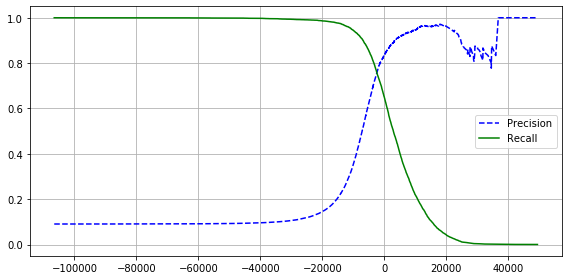

In [16]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(), plt.tight_layout(), plt.grid()

    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

좋은 precision/recall tradeoff를 선택하기 위한 다른 방법으로는 recall에 대한 precision을 바로 그려보는 것이 있다.

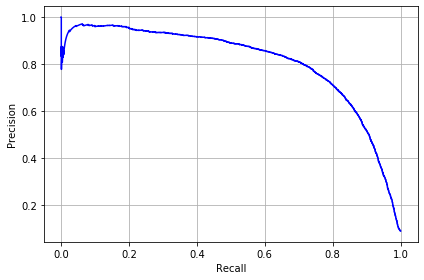

In [17]:
def plot_precision_against_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel("Recall"), plt.ylabel("Precision")
    plt.tight_layout(), plt.grid()

    
plot_precision_against_recall(precisions, recalls)
plt.show()

이제 위의 두 그래프와 함께 프로젝트에 따라 threshold를 결정하면 된다.

예를 들어, 90%의 precision으로 결정했다고 하자. 

첫번째 그래프에 따라 약 4000정도의 threshold를 사용하면 된다. 더 정확한 값은 다음과 같이 90%의 precision을 갖는 가장 낮은 threshold 값을 찾으면 된다.

In [18]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


따라서, 정확히는 3370의 threshold가 90%의 precision 지점이라는 것을 알 수 있다.

training set에 대한 prediction을 하기 위해서는, classifier의 `predict()` 대신에 다음과 같이 실행하면 된다.

In [19]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(y_train_pred_90)

[False False False ...  True False False]


precision과 recall을 확인해보자.

In [20]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


이제 90%의 precision을 가지는 classifier를 사용할 수 있게 되었다

## The ROC Curve

binary classifier에서 앞의 두 그래프와 함께 일반적으로 사용되는 또 하나는 ROC curve이다.

**ROC(receiver operating characteristic)** curve는 **FPR(false positive rate)**에 대한 **TPR(true positive rate, recall)**를 나타낸다. 

- FPR
    - positive로 잘못 분류된 negative instance의 비율
    - $FPR = \dfrac{FP}{TN+FP} = 1-TNR = 1-specificity$
- TNR
    - negative로 정확히 분류된 negative instance의 비율
    - *specificity* 라고도 부름
    - $TNR = \dfrac{TN}{TN+FP}$
    
따라서, ROC curve는 sensitivity(recall) vs 1-specificity를 plot하는 것이다.

ROC curve를 plot하기 위해서는 먼저 TPR와 FPR를 여러 threshold 값에 대해 계산해야 한다. 이는 `roc_curve()`로 다음과 같이 수행할 수 있다.

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그 후, Matplotlib를 사용해 FPR에 대한 TPR을 plot한다.

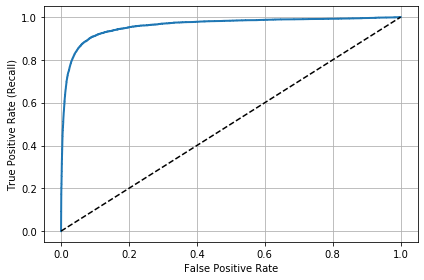

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.tight_layout(), plt.grid()

    
plot_roc_curve(fpr, tpr)
plt.show()

ROC curve에도 높은 recall(TPR)은 FPR을 증가시키는 tradeoff가 있다.

위 그래프의 대각 점선은 purely random classifier를 의미하며 점선에서 왼쪽 상단으로 멀어질 수록 좋은 성능의 classifier를 의미한다.

ROC curve에서 classifier를 비교하는 한 방법은 AUC(area under the curve)를 측정하는 것이다.

perfect classifier는 ROC AUC가 1이고, purely random classifier는 ROC AUC가 0.5이다. 사이킷런은 ROC AUC를 계산하는 함수를 제공한다.

In [23]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


`RandomForestClassifier`를 학습시켜 `SGDClassifier`와 ROC curve 및 ROC AUC score를 비교해보자.

먼저, 각 instance에 대한 score를 계산해야 하는데 RandomForestClassifier에는 `decision_function()`이 없으므로, 대신에 `predict_proba()`를 사용한다.

`predict_proba()`는 instance별 row와 class별 column으로 이루어진 array에 해당 instance의 주어진 class를 가질 확률을 반환한다.

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

print(y_probas_forest)

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]


하지만 확률이 아닌 score가 필요하므로, positive class의 확률을 score로 사용한다.

In [25]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

이제 ROC curve를 그려보자.

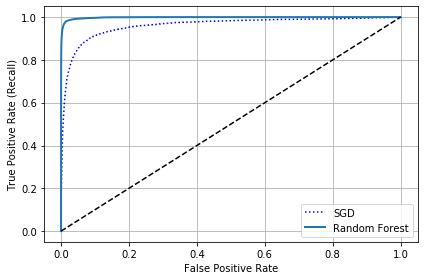

In [26]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend()
plt.show()

Random Forest의 ROC curve가 좌상단에 더 가까우므로, SGD보다 더욱 좋다는 것을 알 수 있다. 

ROC AUC score도 다음과 같이 훨씬 좋다는 것을 알 수 있다.

In [27]:
print(f"SGD\t\t: {roc_auc_score(y_train_5, y_scores)}")
print(f"Random Forest\t: {roc_auc_score(y_train_5, y_scores_forest)}")

SGD		: 0.9604938554008616
Random Forest	: 0.9983436731328145
